# Exploratory Notebook

### Exploring the Data

importing pandas with its alias pd

In [69]:
import pandas as pd
import CustomLibrary as cl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns

Unzipping the zipped data files (all at once)

In [2]:
#!find . -name '*.tsv.gz' -exec gzip -d {} \;

Reading in all the data files to understand which ones will help answer our business questions. Checking the files with .head() and .tail() methods to view a section of the data. The .shape method will help tell how many rows we have in each data set. The .info() method will help discover the dtypes of the columns and possible missing values.

In [3]:
df0= pd.read_csv('./data/zippedData/imdb.name.basics.csv')
df0.head()
#df0.shape

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [4]:
df1= pd.read_csv('./data/zippedData/bom.movie_gross.csv')
df1.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
df2= pd.read_csv('./data/zippedData/imdb.title.akas.csv')
df2.head()

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


The dataset below gives us important information about the movies. Important columns: primary_title, start_year, and genres.

In [6]:
df3= pd.read_csv('./data/zippedData/imdb.title.basics.csv')
df3.head()
df_title_movie = df3.rename(columns = {'primary_title':'movie'})
df_title_movie.head()

,tconst,movie,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


Changed the primary_title to 'movie' so that the merge with the next important data set goes smoothly. 

In [7]:
df_title_movie.describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [8]:
df4= pd.read_csv('./data/zippedData/imdb.title.crew.csv')
df4.head()

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [9]:
df5= pd.read_csv('./data/zippedData/imdb.title.principals.csv')
df5.head()

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [10]:
df6= pd.read_csv('./data/zippedData/imdb.title.ratings.csv')
df6.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [11]:
df7= pd.read_csv('./data/zippedData/tmdb.movies.csv')
df7.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


Found the next file to be one of the important files to gain an understanding of the costs and profits of different movies.

In [12]:
df8= pd.read_csv('./data/zippedData/tn.movie_budgets.csv')
df8['start_year']= [int(x[-4:]) for x in df8['release_date']]
df8.head()
#df8.loc[df8['domestic_gross'] == '$0']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017


Created a new column called start_year that creates a year integer from the string from release_date. This is another qualifier for merging this dataset and the one chosen from above.

### Cleaning the Data

First, merging the datasets so that we have all the information we need in one dataframe.
    The 'inner' join is chosen because each dataset has important data for the analysis. Not having both sides of the dataset makes the row useless in our chosen analysis. The merge is on 'movie' and 'start_year' to make sure that duplicates are at a minimum from having movies with the same name, but different release years.
    We also check for duplicates and drop the rows from our merged dataset.

In [13]:
df_budget_merge = pd.merge(df8, df_title_movie, how = 'inner', on = ('movie', 'start_year'))
df_duplicates = df_budget_merge[df_budget_merge['movie'].duplicated()]
#df_budget_merge.loc[df_budget_merge['domestic_gross'] == '$0'].head()
df_budget_merge.drop(df_duplicates.index, axis = 0, inplace = True)
#df_budget_merge.head()

We next check for missing values. We use worlwide_gross as a check to see if any data necessary for profit calculation is missing. If it is, we drop the row because filling the missing values would throw off our analysis and it does not account for more recently, stream only movies like from Netflix. We want to check only movies from the box office.

In [14]:
df_no_values = df_budget_merge.loc[df_budget_merge['worldwide_gross'] == '$0']
df_budget_merge.drop(df_no_values.index, axis = 0, inplace = True)

Below is a function to change any string numbers into integers so we can use them for stats calculation.

In [15]:
def clean_dollars(dataframe, column_str):
    dataframe[column_str] = dataframe[column_str].str.replace(',', '').str.replace('$', '').astype(int)
    return dataframe

clean_dollars(df_budget_merge, 'production_budget')
clean_dollars(df_budget_merge, 'domestic_gross')
clean_dollars(df_budget_merge, 'worldwide_gross')
df_budget_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1542
Data columns (total 11 columns):
id                   1365 non-null int64
release_date         1365 non-null object
movie                1365 non-null object
production_budget    1365 non-null int64
domestic_gross       1365 non-null int64
worldwide_gross      1365 non-null int64
start_year           1365 non-null int64
tconst               1365 non-null object
original_title       1365 non-null object
runtime_minutes      1359 non-null float64
genres               1365 non-null object
dtypes: float64(1), int64(5), object(5)
memory usage: 128.0+ KB


Next we create an advertisement column to add another important cost to producing a movie. Due to not having the data, we chose to follow the heuristic that advertisement budgets will generally be equal to production budgets. With the costs, we create a profit column from the differnce between the worldwide_gross column and the production_budget and advertisement_budget columns.

In [16]:
df_budget_merge['advertisement_budget'] = df_budget_merge['production_budget']
df_budget_merge['profit'] = df_budget_merge['worldwide_gross'] - df_budget_merge['production_budget'] - df_budget_merge['advertisement_budget']
df_budget_merge.head(20)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,tconst,original_title,runtime_minutes,genres,advertisement_budget,profit
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",410600000,224463875
1,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019,tt6565702,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",350000000,-550237650
2,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,tt2395427,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",330600000,741813963
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",300000000,1448134200
4,9,"Nov 17, 2017",Justice League,300000000,229024295,655945209,2017,tt0974015,Justice League,120.0,"Action,Adventure,Fantasy",300000000,55945209
5,10,"Nov 6, 2015",Spectre,300000000,200074175,879620923,2015,tt2379713,Spectre,148.0,"Action,Adventure,Thriller",300000000,279620923
6,11,"Jul 20, 2012",The Dark Knight Rises,275000000,448139099,1084439099,2012,tt1345836,The Dark Knight Rises,164.0,"Action,Thriller",275000000,534439099
7,12,"May 25, 2018",Solo: A Star Wars Story,275000000,213767512,393151347,2018,tt3778644,Solo: A Star Wars Story,135.0,"Action,Adventure,Fantasy",275000000,-156848653
8,13,"Jul 2, 2013",The Lone Ranger,275000000,89302115,260002115,2013,tt1210819,The Lone Ranger,150.0,"Action,Adventure,Western",275000000,-289997885
9,14,"Mar 9, 2012",John Carter,275000000,73058679,282778100,2012,tt0401729,John Carter,132.0,"Action,Adventure,Sci-Fi",275000000,-267221900


We decide to sort the dataset by the profit values, with greatest profit being at the top.

In [17]:
df_budget_merge.sort_values(by = ['profit'], axis = 0, ascending = False, inplace = True)

### Using Genres

Next we check what type of genres are in each row.

In [18]:
df_budget_merge.genres.value_counts()

Adventure,Animation,Comedy      67
Action,Adventure,Sci-Fi         51
Comedy,Drama,Romance            48
Comedy                          48
Drama                           43
                                ..
Comedy,Sci-Fi                    1
Action,Biography,Documentary     1
Adventure,Comedy,Music           1
Romance,Sci-Fi,Thriller          1
Biography,Drama,Mystery          1
Name: genres, Length: 214, dtype: int64

We decide to use only certain common genres instead of the 214 possible collection of genres.

In [19]:
# df_budget_merge['comedy_id'] = [1 if 'Comedy' in x
#                                 else 0 
#                                 for x in df_budget_merge['genres']]
# df_budget_merge['drama_id'] = [1 if 'Drama' in x
#                                 else 0 
#                                 for x in df_budget_merge['genres']]
# df_budget_merge['action_id'] = [1 if 'Action' in x
#                                 else 0 
#                                 for x in df_budget_merge['genres']]
# df_budget_merge.head()

We create a column to have a better understanding of the genres in each movie.

In [20]:
#df_budget_merge['genre_tuple'] = list(zip(df_budget_merge['comedy_id'], df_budget_merge['drama_id'], df_budget_merge['action_id']))

In [21]:
cl.indicator_str_parser(df_budget_merge, 'genres', ['Action', 'Adventure', 'Comedy', 'Drama', 'Family', 'Thriller', 'Documentary'])

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,tconst,original_title,runtime_minutes,...,genres_not_parsed_id,genres_Action_id,genres_Adventure_id,genres_Comedy_id,genres_Drama_id,genres_Family_id,genres_Thriller_id,genres_Documentary_id,genres_tuple,genres_num_of_parses
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,tt4154756,Avengers: Infinity War,149,...,0,1,1,0,0,0,0,0,"(1, 1, 0, 0, 0, 0, 0)",2
23,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2015,tt0369610,Jurassic World,124,...,0,1,1,0,0,0,0,0,"(1, 1, 0, 0, 0, 0, 0)",2
46,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,2015,tt2820852,Furious Seven,137,...,0,1,0,0,0,0,1,0,"(1, 0, 0, 0, 0, 1, 0)",2
18,27,"May 4, 2012",The Avengers,225000000,623279547,1517935897,2012,tt0848228,The Avengers,143,...,0,1,1,0,0,0,0,0,"(1, 1, 0, 0, 0, 0, 0)",2
301,73,"Jul 10, 2015",Minions,74000000,336045770,1160336173,2015,tt2293640,Minions,91,...,0,0,1,1,0,0,0,0,"(0, 1, 1, 0, 0, 0, 0)",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,42,"Jun 14, 2019",Men in Black: International,110000000,3100000,3100000,2019,tt2283336,Men in Black: International,115,...,0,1,1,1,0,0,0,0,"(1, 1, 1, 0, 0, 0, 0)",3
124,94,"Mar 11, 2011",Mars Needs Moms,150000000,21392758,39549758,2011,tt1305591,Mars Needs Moms,88,...,0,0,1,0,0,1,0,0,"(0, 1, 0, 0, 1, 0, 0)",2
9,14,"Mar 9, 2012",John Carter,275000000,73058679,282778100,2012,tt0401729,John Carter,132,...,0,1,1,0,0,0,0,0,"(1, 1, 0, 0, 0, 0, 0)",2
8,13,"Jul 2, 2013",The Lone Ranger,275000000,89302115,260002115,2013,tt1210819,The Lone Ranger,150,...,0,1,1,0,0,0,0,0,"(1, 1, 0, 0, 0, 0, 0)",2


WE next check to see which movies are missing from our previous genre categories.

In [22]:
df_budget_merge.loc[df_budget_merge['genres_tuple'] == (0, 0, 0, 0, 0, 0, 0)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,tconst,original_title,runtime_minutes,...,genres_not_parsed_id,genres_Action_id,genres_Adventure_id,genres_Comedy_id,genres_Drama_id,genres_Family_id,genres_Thriller_id,genres_Documentary_id,genres_tuple,genres_num_of_parses
1303,65,"Oct 20, 2010",Paranormal Activity 2,3000000,84752907,177512032,2010,tt1536044,Paranormal Activity 2,91,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
1423,12,"Jan 6, 2012",The Devil Inside,1000000,53262945,101759490,2012,tt1560985,The Devil Inside,83,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
1061,61,"Oct 27, 2017",Jigsaw,10000000,38052832,102445196,2017,tt3348730,Jigsaw,92,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
505,49,"Aug 12, 2011",Final Destination 5,40000000,42587643,155011165,2011,tt1622979,Final Destination 5,92,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
1222,76,"Feb 27, 2015",The Lazarus Effect,5000000,25801570,38359310,2015,tt2918436,The Lazarus Effect,83,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
1224,79,"Mar 9, 2018",The Strangers: Prey at Night,5000000,24431472,29960051,2018,tt1285009,The Strangers: Prey at Night,85,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
1228,94,"Sep 2, 2011",Apollo 18,5000000,17686929,26517819,2011,tt1772240,Apollo 18,86,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
508,55,"Apr 15, 2011",Scream 4,40000000,38180928,95989590,2011,tt1262416,Scream 4,111,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
1426,29,"Jul 20, 2018",Unfriended: Dark Web,1000000,8866745,16434588,2018,tt4761916,Unfriended: Dark Web,92,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0
1232,4,"Jun 9, 2017",It Comes at Night,5000000,13985117,19720203,2017,tt4695012,It Comes at Night,91,...,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0)",0


In [23]:
df_budget_merge.loc[df_budget_merge['genres_tuple'] == (0, 0, 0, 0, 0, 0, 0)].genres.value_counts()

Horror                    10
Crime,Horror,Mystery       4
Horror,Mystery,Sci-Fi      3
Fantasy,Horror,Mystery     2
Horror,Mystery             2
Music                      1
Musical                    1
Fantasy                    1
Horror,Sci-Fi              1
Name: genres, dtype: int64

In [24]:
df_budget_merge.describe()

,id,production_budget,domestic_gross,worldwide_gross,start_year,advertisement_budget,profit,genres_not_parsed_id,genres_Action_id,genres_Adventure_id,genres_Comedy_id,genres_Drama_id,genres_Family_id,genres_Thriller_id,genres_Documentary_id,genres_num_of_parses
count,1365.000000,1.365000e+03,1.365000e+03,1.365000e+03,1365.000000,1.365000e+03,1.365000e+03,1365.0,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000
mean,50.795604,4.811613e+07,6.117461e+07,1.533262e+08,2013.866667,4.811613e+07,5.709391e+07,0.0,0.306227,0.249817,0.353114,0.486447,0.063004,0.169963,0.023443,1.652015
std,28.458309,5.720284e+07,8.684681e+07,2.401767e+08,2.607475,5.720284e+07,1.671892e+08,0.0,0.461094,0.433066,0.478113,0.499999,0.243059,0.375738,0.151362,0.663075
min,1.000000,2.500000e+04,0.000000e+00,2.600000e+01,2010.000000,2.500000e+04,-5.502376e+08,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,1.000000e+07,6.810754e+06,1.536230e+07,2012.000000,1.000000e+07,-1.405621e+07,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,51.000000,2.600000e+07,3.307827e+07,6.259916e+07,2014.000000,2.600000e+07,5.885836e+06,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,75.000000,6.000000e+07,7.426203e+07,1.735676e+08,2016.000000,6.000000e+07,6.404180e+07,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000
max,100.000000,4.106000e+08,7.000596e+08,2.048134e+09,2019.000000,4.106000e+08,1.448134e+09,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [25]:
df_budget_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 3 to 1
Data columns (total 23 columns):
id                       1365 non-null int64
release_date             1365 non-null object
movie                    1365 non-null object
production_budget        1365 non-null int64
domestic_gross           1365 non-null int64
worldwide_gross          1365 non-null int64
start_year               1365 non-null int64
tconst                   1365 non-null object
original_title           1365 non-null object
runtime_minutes          1359 non-null object
genres                   1365 non-null object
advertisement_budget     1365 non-null int64
profit                   1365 non-null int64
genres_not_parsed_id     1365 non-null int64
genres_Action_id         1365 non-null int64
genres_Adventure_id      1365 non-null int64
genres_Comedy_id         1365 non-null int64
genres_Drama_id          1365 non-null int64
genres_Family_id         1365 non-null int64
genres_Thriller_id       1365 non-n

In [26]:
df_budget_merge.genres_tuple.value_counts()

(0, 0, 0, 1, 0, 0, 0)    280
(0, 0, 1, 1, 0, 0, 0)    135
(0, 0, 1, 0, 0, 0, 0)    130
(1, 1, 0, 0, 0, 0, 0)    120
(0, 1, 1, 0, 0, 0, 0)     85
(0, 0, 0, 1, 0, 1, 0)     78
(1, 0, 0, 1, 0, 0, 0)     72
(0, 0, 0, 0, 0, 1, 0)     71
(1, 0, 1, 0, 0, 0, 0)     54
(1, 0, 0, 0, 0, 1, 0)     53
(1, 0, 0, 0, 0, 0, 0)     30
(0, 0, 0, 0, 0, 0, 1)     26
(1, 1, 0, 1, 0, 0, 0)     26
(0, 0, 0, 0, 0, 0, 0)     25
(1, 1, 1, 0, 0, 0, 0)     21
(0, 1, 0, 0, 1, 0, 0)     20
(0, 0, 1, 0, 1, 0, 0)     18
(0, 1, 0, 1, 0, 0, 0)     17
(0, 0, 0, 1, 1, 0, 0)     14
(1, 0, 0, 1, 0, 1, 0)     13
(1, 1, 0, 0, 0, 1, 0)     12
(0, 1, 1, 0, 1, 0, 0)     11
(0, 1, 1, 1, 0, 0, 0)     10
(0, 1, 0, 0, 0, 0, 0)      6
(1, 1, 0, 0, 1, 0, 0)      6
(0, 1, 0, 1, 1, 0, 0)      5
(0, 0, 1, 1, 1, 0, 0)      5
(1, 0, 1, 1, 0, 0, 0)      4
(0, 0, 1, 0, 0, 0, 1)      3
(0, 0, 1, 0, 0, 1, 0)      3
(0, 1, 0, 1, 0, 1, 0)      2
(0, 0, 0, 0, 1, 0, 0)      2
(1, 0, 1, 0, 1, 0, 0)      2
(1, 0, 0, 1, 1, 0, 0)      2
(1, 0, 0, 0, 0

In [27]:
df_budget_merge['ROI'] = df_budget_merge['profit'] / (df_budget_merge['production_budget'] + df_budget_merge['advertisement_budget']) * 100

In [28]:
df_budget_merge['total_costs'] = df_budget_merge['production_budget'] + df_budget_merge['advertisement_budget']

In [29]:
df_budget_merge.loc[df_budget_merge['ROI'] == df_budget_merge['ROI'].max()]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,tconst,original_title,runtime_minutes,...,genres_Adventure_id,genres_Comedy_id,genres_Drama_id,genres_Family_id,genres_Thriller_id,genres_Documentary_id,genres_tuple,genres_num_of_parses,ROI,total_costs
1521,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,tt2309260,The Gallows,81,...,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 1, 0)",1,20728.237,200000


In [30]:
df_budget_merge.describe()

,id,production_budget,domestic_gross,worldwide_gross,start_year,advertisement_budget,profit,genres_not_parsed_id,genres_Action_id,genres_Adventure_id,genres_Comedy_id,genres_Drama_id,genres_Family_id,genres_Thriller_id,genres_Documentary_id,genres_num_of_parses,ROI,total_costs
count,1365.000000,1.365000e+03,1.365000e+03,1.365000e+03,1365.000000,1.365000e+03,1.365000e+03,1365.0,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1.365000e+03
mean,50.795604,4.811613e+07,6.117461e+07,1.533262e+08,2013.866667,4.811613e+07,5.709391e+07,0.0,0.306227,0.249817,0.353114,0.486447,0.063004,0.169963,0.023443,1.652015,98.385315,9.623225e+07
std,28.458309,5.720284e+07,8.684681e+07,2.401767e+08,2.607475,5.720284e+07,1.671892e+08,0.0,0.461094,0.433066,0.478113,0.499999,0.243059,0.375738,0.151362,0.663075,627.543212,1.144057e+08
min,1.000000,2.500000e+04,0.000000e+00,2.600000e+01,2010.000000,2.500000e+04,-5.502376e+08,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99.998700,5.000000e+04
25%,26.000000,1.000000e+07,6.810754e+06,1.536230e+07,2012.000000,1.000000e+07,-1.405621e+07,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-49.491100,2.000000e+07
50%,51.000000,2.600000e+07,3.307827e+07,6.259916e+07,2014.000000,2.600000e+07,5.885836e+06,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,15.639407,5.200000e+07
75%,75.000000,6.000000e+07,7.426203e+07,1.735676e+08,2016.000000,6.000000e+07,6.404180e+07,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,109.013108,1.200000e+08
max,100.000000,4.106000e+08,7.000596e+08,2.048134e+09,2019.000000,4.106000e+08,1.448134e+09,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,20728.237000,8.212000e+08


## Visualizations

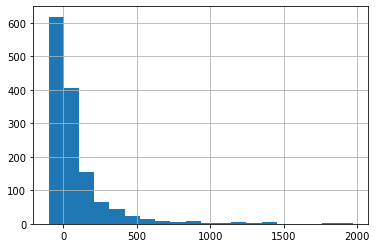

In [31]:
#df_budget_merge['total_costs'].loc[df_budget_merge['total_costs'] < 200000000].hist(bins = 25)
#df_budget_merge['total_costs'].hist(bins = 100)
df_budget_merge['ROI'].loc[df_budget_merge['ROI'] < 2000].hist(bins = 20)
plt.show()

In [32]:
#df_budget_merge.to_csv('Cleaned_Data.csv')

In [33]:
df_budget_merge['budget_category'] = df_budget_merge['total_costs'].apply(lambda x: 'low' if x < 25000000 else ('mid' if x < 100000000 else 'high' ))

In [34]:
df_budget_merge.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,tconst,original_title,runtime_minutes,...,genres_Comedy_id,genres_Drama_id,genres_Family_id,genres_Thriller_id,genres_Documentary_id,genres_tuple,genres_num_of_parses,ROI,total_costs,budget_category
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,tt4154756,Avengers: Infinity War,149,...,0,0,0,0,0,"(1, 1, 0, 0, 0, 0, 0)",2,241.355700,600000000,high
23,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2015,tt0369610,Jurassic World,124,...,0,0,0,0,0,"(1, 1, 0, 0, 0, 0, 0)",2,283.454620,430000000,high
46,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,2015,tt2820852,Furious Seven,137,...,0,0,0,1,0,"(1, 0, 0, 0, 0, 1, 0)",2,299.663893,380000000,high
18,27,"May 4, 2012",The Avengers,225000000,623279547,1517935897,2012,tt0848228,The Avengers,143,...,0,0,0,0,0,"(1, 1, 0, 0, 0, 0, 0)",2,237.319088,450000000,high
301,73,"Jul 10, 2015",Minions,74000000,336045770,1160336173,2015,tt2293640,Minions,91,...,1,0,0,0,0,"(0, 1, 1, 0, 0, 0, 0)",2,684.010928,148000000,high


In [35]:
df_budget_merge.loc[df_budget_merge['genres_Action_id'] == 1].ROI.median()

11.42687342548077

In [36]:
genre_action = df_budget_merge.loc[df_budget_merge['genres_Action_id'] == 1]
genre_action['name'] = 'Action'
genre_adventure = df_budget_merge.loc[df_budget_merge['genres_Adventure_id'] == 1]
genre_adventure['name'] = 'Adventure'
genre_comedy = df_budget_merge.loc[df_budget_merge['genres_Comedy_id'] == 1]
genre_comedy['name'] = 'Comedy'
genre_drama = df_budget_merge.loc[df_budget_merge['genres_Drama_id'] == 1]
genre_drama['name'] = 'Drama'
genre_family = df_budget_merge.loc[df_budget_merge['genres_Family_id'] == 1]
genre_family['name'] = 'Family'
genre_thriller = df_budget_merge.loc[df_budget_merge['genres_Thriller_id'] == 1]
genre_thriller['name'] = 'Thriller'
genre_documentary = df_budget_merge.loc[df_budget_merge['genres_Documentary_id'] == 1]
genre_documentary['name'] = 'Documentary'
genres = [genre_action, genre_adventure, genre_comedy, genre_drama, genre_family, genre_thriller, genre_documentary]

/Users/malcolmkatzenbach/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/malcolmkatzenbach/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/malcolmkatzenbach/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

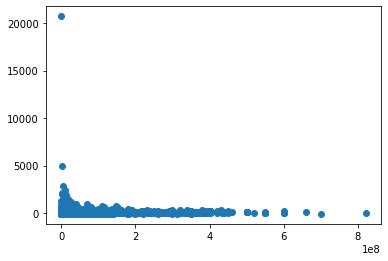

In [37]:

plt.scatter(df_budget_merge['total_costs'], df_budget_merge['ROI'])

plt.show()

### ATTEMPT 1 for Box Plots of Cost vs. ROI: Groupby

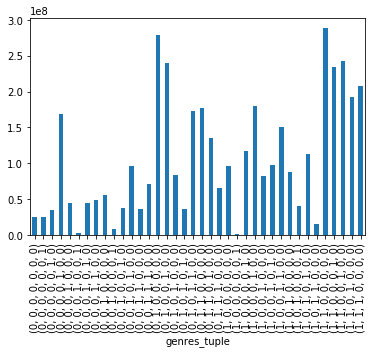

In [38]:
df_budget_merge.groupby('genres_tuple')['total_costs'].mean().plot(kind = 'bar')

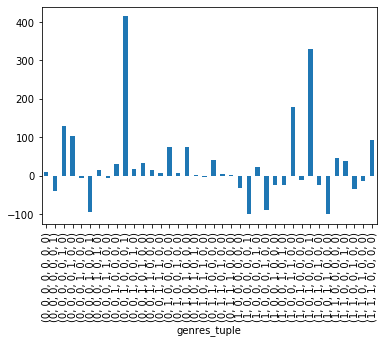

In [39]:
#for x in ['Action', 'Adventure', 'Comedy', 'Drama', 'Family', 'Thriller', 'Documentary']
df_budget_merge.groupby('genres_tuple')['ROI'].median().plot(kind = 'bar')

### ATTEMPT 2 for Box Plots of Cost vs. ROI
#### Seperate Genres into Individual DataFrames

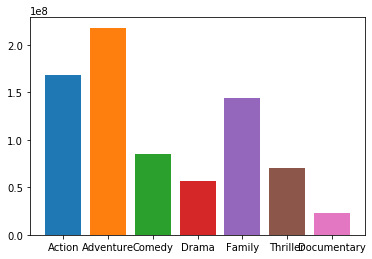

In [40]:
fig = plt.figure()
for genre in genres:
    plt.bar(genre['name'], genre['total_costs'].mean())

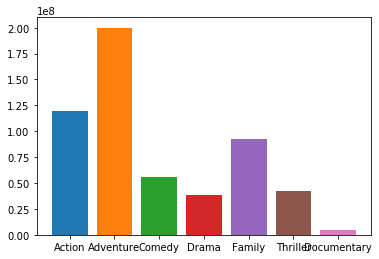

In [41]:
fig = plt.figure()
for genre in genres:
    plt.bar(genre['name'], genre['total_costs'].median())

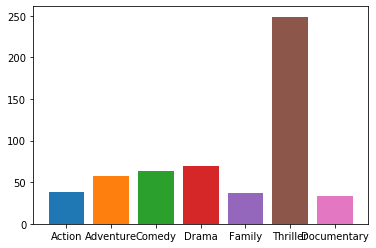

In [42]:
fig = plt.figure()
for genre in genres:
    plt.bar(genre['name'], genre['ROI'].mean())

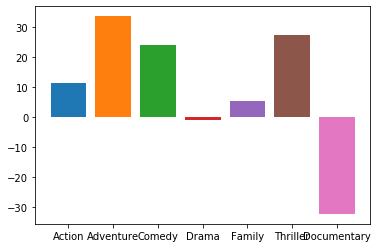

In [43]:
fig = plt.figure()
for genre in genres:
    plt.bar(genre['name'], genre['ROI'].median())

### Cleaning Up Attempt 2 Box Plots

In [44]:
def Genres_DF(df, ls_of_genres):
    df_list = []
    for genre in ls_of_genres:
        'genre_' + genre = df.loc[df['genres_'+ genre +'_id'] == 1]
        df_list.append('genre_'+ genre)
    return df_list
        

SyntaxError: can't assign to operator (<ipython-input-44-af33acebb6b6>, line 4)

We want to know how the Rate on Investment changes with genre. Or: How does genre affect the Rate on Investment of Movies? What genres have the best ROI?

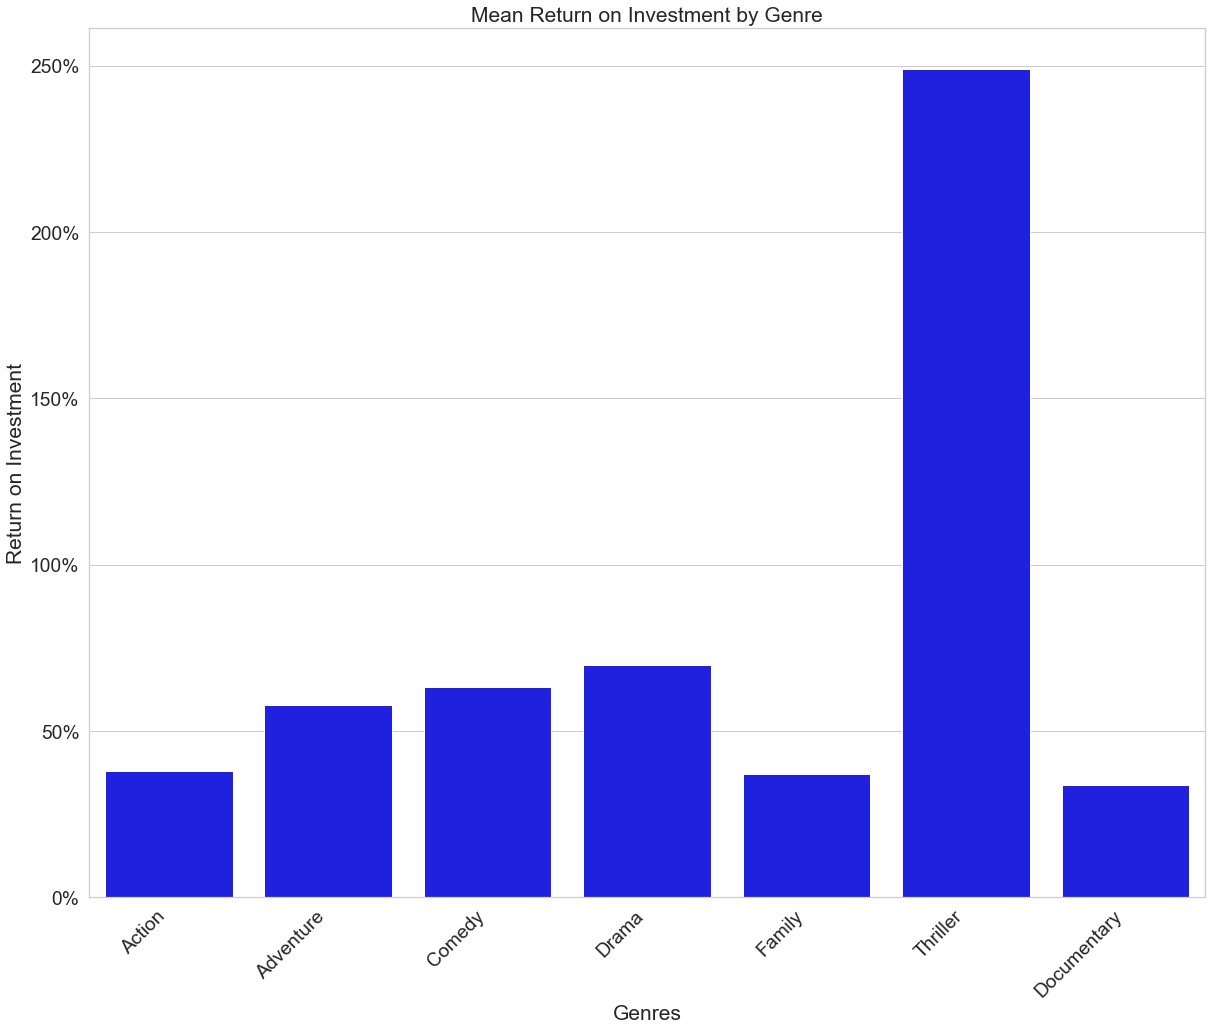

In [83]:

sns.set(font_scale = 1.75, style= 'whitegrid')
x1 = ['Action', 'Adventure', 'Comedy', 'Drama', 'Family', 'Thriller', 'Documentary']
y1 = []
for genre in genres:
#     x1.append(genre['name'])
    y1.append(genre['ROI'].mean())
fig = plt.figure(figsize=(20, 16))
ax = sns.barplot(x = x1, y = y1, color = 'blue')
ax.set(title = 'Mean Return on Investment by Genre', xlabel = 'Genres', ylabel = 'Return on Investment')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#fig.savefig('Average_Return_on_Investment_by_Genre.png');

We see that the top 3 genres for ROI are: Adventure, Thriller, and Comedy. From this we know that the studio should start producing movies in one of these three genres.

We want to know how much it costs to produce movies of certain genres. What are the cheapest movies to produce by genre?

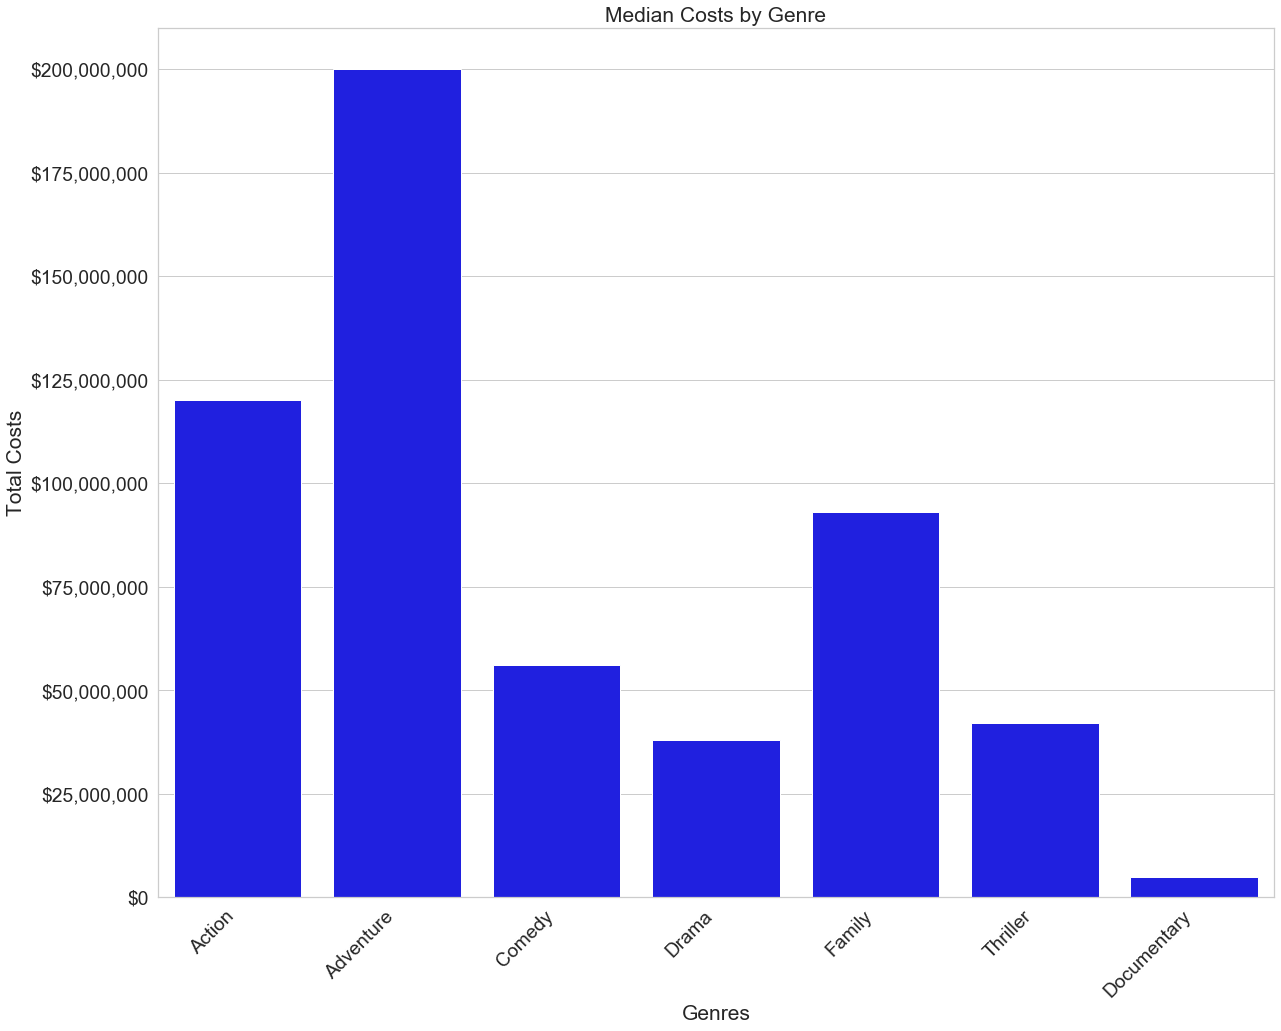

In [82]:
sns.set_style('whitegrid')
x1 = ['Action', 'Adventure', 'Comedy', 'Drama', 'Family', 'Thriller', 'Documentary']
y1 = []
for genre in genres:
#     x1.append(genre['name'])
    y1.append(genre['total_costs'].median())
fig = plt.figure(figsize = (20, 16))
ax = sns.barplot(x = x1, y = y1, color = 'blue')
ax.set(title = 'Median Costs by Genre', xlabel = 'Genres', ylabel = 'Total Costs')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#fig.savefig('Median_Costs_by_Genre.png');

The cheapest movies to produce are Documentaries, Dramas, and Thrillers. Adventure, Action, and Family movies are the most expensive to produce. Taken in context of the previous graph, we should produce comedies and thrillers for cheapest investment and highest ROI. If the studio is willing to gamble, Adventure would bring in the highest profit. It takes a lot of investment, but is most likely to do well in the box office.

In [48]:
action = df_budget_merge[df_budget_merge['genres_Action_id'] == 1]
adventure = df_budget_merge[df_budget_merge['genres_Adventure_id'] == 1]
comedy = df_budget_merge[df_budget_merge['genres_Comedy_id'] == 1]
family = df_budget_merge[df_budget_merge['genres_Family_id'] == 1]
thriller = df_budget_merge[df_budget_merge['genres_Thriller_id'] == 1]
documentary = df_budget_merge[df_budget_merge['genres_Documentary_id'] == 1]
other = df_budget_merge[df_budget_merge['genres_tuple'] == '(0, 0, 0, 0, 0, 0, 0)']
drama = df_budget_merge[df_budget_merge['genres_Drama_id'] == 1]

In [ ]:
fig = plt.figure()
ax = sns.barplot(x = x1, y = y1, color = 'blue')

In [49]:
new_df = pd.DataFrame(columns = ['genre_budget', 'genre', 'ROI', 'budget_category'])
new_df

,genre_budget,genre,ROI,budget_category


In [50]:
new_df['ROI'] = [df_budget_merge.loc[(df_budget_merge['genres_Action_id'] == 1) & 
                                    (df_budget_merge['total_costs'] >= 100000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Action_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 100000000) & 
                                    (df_budget_merge['total_costs'] >= 25000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Action_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 25000000)].ROI.median(),
                df_budget_merge.loc[(df_budget_merge['genres_Adventure_id'] == 1) & 
                                    (df_budget_merge['total_costs'] >= 100000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Adventure_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 100000000) & 
                                    (df_budget_merge['total_costs'] >= 25000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Adventure_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 25000000)].ROI.median(),
                df_budget_merge.loc[(df_budget_merge['genres_Comedy_id'] == 1) & 
                                    (df_budget_merge['total_costs'] >= 100000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Comedy_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 100000000) & 
                                    (df_budget_merge['total_costs'] >= 25000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Comedy_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 25000000)].ROI.median(),
                df_budget_merge.loc[(df_budget_merge['genres_Drama_id'] == 1) & 
                                    (df_budget_merge['total_costs'] >= 100000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Drama_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 100000000) & 
                                    (df_budget_merge['total_costs'] >= 25000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Drama_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 25000000)].ROI.median(),
                df_budget_merge.loc[(df_budget_merge['genres_Family_id'] == 1) & 
                                    (df_budget_merge['total_costs'] >= 100000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Family_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 100000000) & 
                                    (df_budget_merge['total_costs'] >= 25000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Family_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 25000000)].ROI.median(),
                df_budget_merge.loc[(df_budget_merge['genres_Thriller_id'] == 1) & 
                                    (df_budget_merge['total_costs'] >= 100000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Thriller_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 100000000) & 
                                    (df_budget_merge['total_costs'] >= 25000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Thriller_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 25000000)].ROI.median(),
                df_budget_merge.loc[(df_budget_merge['genres_Documentary_id'] == 1) & 
                                    (df_budget_merge['total_costs'] >= 100000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Documentary_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 100000000) & 
                                    (df_budget_merge['total_costs'] >= 25000000)].ROI.median(), 
                df_budget_merge.loc[(df_budget_merge['genres_Documentary_id'] == 1) & 
                                    (df_budget_merge['total_costs'] < 25000000)].ROI.median()]
new_df['budget_category'] = ['high', 'mid', 'low',
                            'high', 'mid', 'low',
                            'high', 'mid', 'low',
                            'high', 'mid', 'low',
                            'high', 'mid', 'low',
                            'high', 'mid', 'low',
                            'high', 'mid', 'low']
new_df['genre'] = ['Action', 'Action', 'Action', 'Adventure', 'Adventure', 'Adventure', 'Comedy', 'Comedy', 'Comedy',
                  'Drama', 'Drama', 'Drama', 'Family', 'Family', 'Family', 'Thriller', 'Thriller', 'Thriller', 
                  'Documentary', 'Documentary', 'Documentary']



In [51]:
new_df

,genre_budget,genre,ROI,budget_category
0,NaN,Action,31.447301,high
1,NaN,Action,-12.810407,mid
2,NaN,Action,-76.194825,low
3,NaN,Adventure,43.843827,high
4,NaN,Adventure,11.526821,mid
5,NaN,Adventure,-67.418153,low
6,NaN,Comedy,38.576075,high
7,NaN,Comedy,17.300534,mid
8,NaN,Comedy,3.172333,low
9,NaN,Drama,6.661734,high


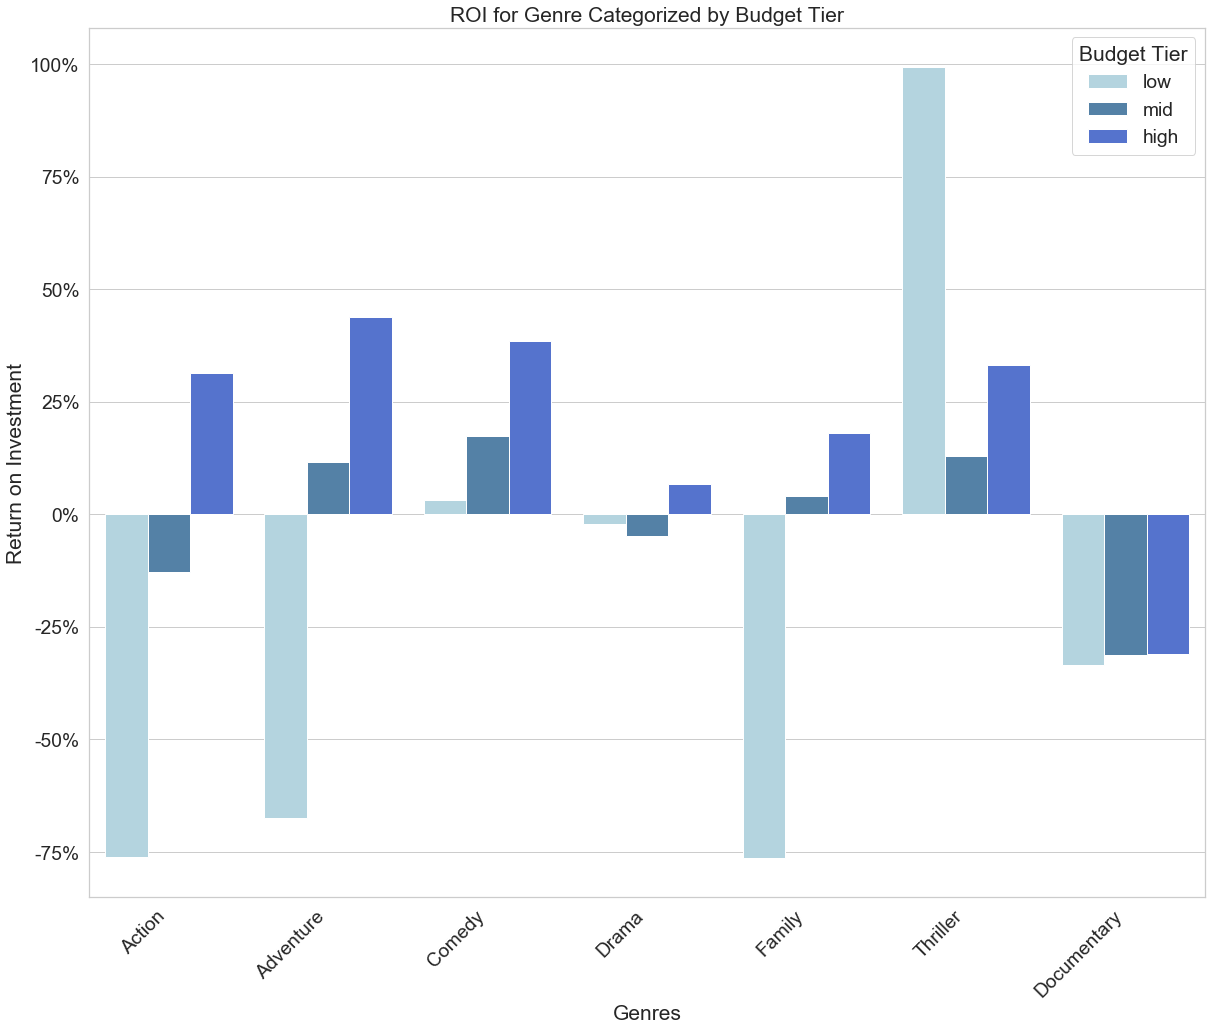

In [84]:
fig = plt.figure(figsize= (20, 16))
ax = sns.barplot(data = new_df, x = 'genre', y = 'ROI', hue = 'budget_category', palette=sns.color_palette(['lightblue', 'steelblue', 'royalblue']), hue_order = ['low', 'mid', 'high'])
ax.set(title = 'ROI for Genre Categorized by Budget Tier', xlabel = 'Genres', ylabel = 'Return on Investment')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
ax.legend(title = 'Budget Tier')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#fig.savefig('ROI_for_Genre_Categorized_by_Budget_Tier.png');

In [ ]:
df9= pd.read_csv('./data/zippedData/rt.movie_info.tsv', sep = '\t')
df9.head()

In [ ]:
df10= pd.read_csv('./data/zippedData/rt.reviews.tsv', sep = '\t', encoding = 'latin-1')
df10.head()

In [ ]:
df11= pd.read_csv('./data/zippedData/bom.movie_gross.csv')
df11.head()